In [1]:
## os library for computer path
import os.path

## numpy library
import numpy as np

## jax library for autodiff
import jax
## enable x64
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
## jax-cosmo library - main driver for producing observables and fisher forecasts
import jax_cosmo as jc
## CCL library - DES official library, serves a cross-check of the Fisher matrix stability in jax-cosmo
import pyccl as ccl

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
## personal preference for matplotlib fonts
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "sans-serif",
    #"font.sans-serif": "Computer Modern",
    "font.size": 22})

# First, we check the implementation of f(z) and D(z) in `jax-cosmo`.

### Define cosmology and utility functions

In [2]:
cosmo_param_nr = 9

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm

def plot_1d_error_frac(cov, fid_vals, names, inds: list, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    #verify that names and inds are of the same length
    assert len(names)==len(inds)

    ax.barh(names, np.sqrt(cov[inds, inds])/np.abs(fid_vals), **kwargs)

def plot_1d_error(cov, names, inds: list, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    #verify that names and inds are of the same length
    assert len(names)==len(inds)

    ax.barh(names, np.sqrt(cov[inds, inds]), **kwargs)

def plot_contours(cov, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])
        
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstds[0] * np.sqrt(vals[0]),
                     height=2.0 * nstds[0] * np.sqrt(vals[1]), angle=theta, alpha=0.8,**kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstds[1] * np.sqrt(vals[0]),
                     height=2.0 * nstds[1] * np.sqrt(vals[1]), angle=theta, alpha=0.2,**kwargs)
    ellips=[ellip1,ellip2]

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(cov, pos, ind, cl=0.9545, ax=None, print_mu_sigma = True, **kwargs):
  mu = pos[ind]
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  x_1sigma = np.linspace(mu-sigma, mu+sigma, num=num, endpoint=True)
  x_2sigma = np.linspace(mu-2*sigma, mu+2*sigma, num=num, endpoint=True)
  
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.fill_between(x_1sigma, np.exp(-.5*((x_1sigma-mu)/sigma)**2), alpha=.8, **kwargs)
  ax.fill_between(x_2sigma, np.exp(-.5*((x_2sigma-mu)/sigma)**2), alpha=.2, **kwargs)
  ax.set_xlim((x[0], x[-1]))
  
  if print_mu_sigma:
    textstr=textstr = '\n'.join((
        r'$\mu=%f.4$' % (mu, ),
        r'$\sigma=%f.4$' % (sigma, )))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
  
  return (mu, sigma)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
PL18_h=0.6732
PL18_omegac=0.12011/(PL18_h**2)
PL18_omegab=0.022383/(PL18_h**2) # won't vary in this example
PL18_sigma8=0.812
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma0=0.55
GR_gamma1=0.


fid_cosmo = jc.Cosmology(Omega_m=PL18_omegac+PL18_omegab,
                         Omega_c=PL18_omegac,
                         Omega_b=PL18_omegab,
                         h=PL18_h,
                         n_s=PL18_ns,
                         sigma8=PL18_sigma8,
                         S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**0.5,
                         Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa,
                         gamma0=GR_gamma0, gamma1=GR_gamma1)
fid_cosmo_nogamma = jc.Cosmology(Omega_m=PL18_omegac+PL18_omegab,
                         Omega_c=PL18_omegac,
                         Omega_b=PL18_omegab,
                         h=PL18_h,
                         n_s=PL18_ns,
                         sigma8=PL18_sigma8,
                         S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**0.5,
                         Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa,
                         gamma0=None, gamma1=None)

## fsigma8(z)

In [5]:
cosmo_param_nr_fsig8 = 2

def get_params_vec_fsig8(cosmo):
#def get_params_vec(cosmo, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    return np.array([ 
        # Cosmological parameters [Omega_m, Omega_b, h, S8, ns, gamma, w0, wa] 
        #cosmo.Omega_k,
        cosmo.Omega_m,
        cosmo.S8,
        #cosmo.w0, cosmo.wa,
        #cosmo.gamma0, cosmo.gamma1
    ])

def unpack_params_vec_fsig8(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr_fsig8]
    return cosmo

fid_params_fsig8 = get_params_vec_fsig8(fid_cosmo)

First, we check the implementation of $f\sigma_8(z)$ in `jax-cosmo` against several $f\sigma_8$ measurements from various sources, summarized in [arXiv:2304.07281v2](https://arxiv.org/abs/2304.07281) Table 2.

In [6]:
from jax_cosmo.background import growth_rate, growth_factor
from jax_cosmo.utils import z2a

def fsigma8(cosmo, z):
    a = z2a(z)
    return growth_rate(cosmo, a)*growth_factor(cosmo, a)*cosmo.sigma8

Text(0, 0.5, '$f\\sigma_8$')

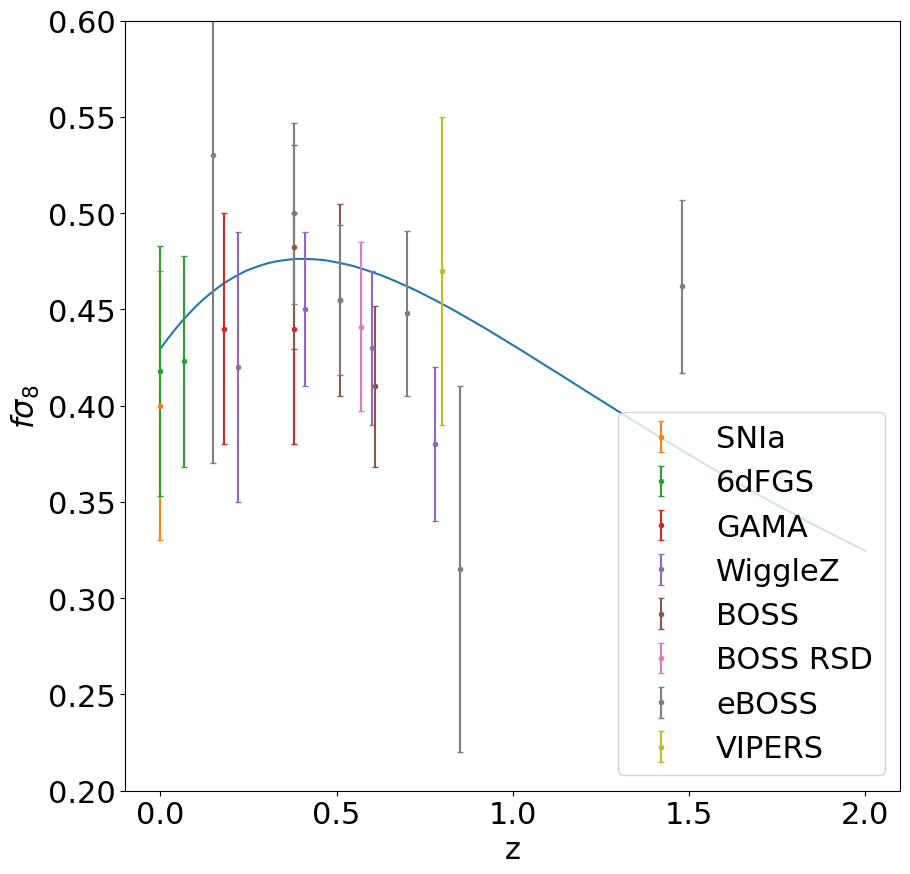

In [7]:
zs = np.linspace(0.001,2,100)


plt.figure(figsize=(10,10))
plt.plot(zs, fsigma8(fid_cosmo, zs))
plt.errorbar([0],[.4], yerr=[.07], label='SNIa', ls='none', marker='.', capsize=2)
plt.errorbar([0,.067],[.418,.423], yerr=[.065,.055], label='6dFGS', ls='none', marker='.', capsize=2)
plt.errorbar([.18, .38],[.44, .44], yerr=[.06,.06], label='GAMA', ls='none', marker='.', capsize=2)
plt.errorbar([.22, .41, .6, .78], [.42, .45, .43, .38], yerr=[.07,.04,.04,.04], label='WiggleZ', ls='none', marker='.', capsize=2)
plt.errorbar([.38, .51, .61], [.4823, .455, .41], yerr=[.053,.05,.042], label='BOSS', ls='none', marker='.', capsize=2)
plt.errorbar([.57], [.441], yerr=[.044], label="BOSS RSD", ls='none', marker='.', capsize=2)
plt.errorbar([.15, .38, .51, .7, .85, 1.48], [.53, .5, .455, .448, .315, .462], yerr=[.16,.047,.039,.043,.095,.045], label='eBOSS', ls='none', marker='.', capsize=2)
plt.errorbar([.8],[.47], yerr=[.08], label='VIPERS', ls='none', marker='.', capsize=2)
plt.ylim((.2,.6))
plt.legend(loc='lower right')

plt.xlabel('z')
plt.ylabel(r'$f\sigma_8$')

In [8]:
z = np.linspace(0, 5, num=10)

In [9]:
print(zs)

[1.00000000e-03 2.11919192e-02 4.13838384e-02 6.15757576e-02
 8.17676768e-02 1.01959596e-01 1.22151515e-01 1.42343434e-01
 1.62535354e-01 1.82727273e-01 2.02919192e-01 2.23111111e-01
 2.43303030e-01 2.63494949e-01 2.83686869e-01 3.03878788e-01
 3.24070707e-01 3.44262626e-01 3.64454545e-01 3.84646465e-01
 4.04838384e-01 4.25030303e-01 4.45222222e-01 4.65414141e-01
 4.85606061e-01 5.05797980e-01 5.25989899e-01 5.46181818e-01
 5.66373737e-01 5.86565657e-01 6.06757576e-01 6.26949495e-01
 6.47141414e-01 6.67333333e-01 6.87525253e-01 7.07717172e-01
 7.27909091e-01 7.48101010e-01 7.68292929e-01 7.88484848e-01
 8.08676768e-01 8.28868687e-01 8.49060606e-01 8.69252525e-01
 8.89444444e-01 9.09636364e-01 9.29828283e-01 9.50020202e-01
 9.70212121e-01 9.90404040e-01 1.01059596e+00 1.03078788e+00
 1.05097980e+00 1.07117172e+00 1.09136364e+00 1.11155556e+00
 1.13174747e+00 1.15193939e+00 1.17213131e+00 1.19232323e+00
 1.21251515e+00 1.23270707e+00 1.25289899e+00 1.27309091e+00
 1.29328283e+00 1.313474

In [10]:
def compute_fsigma8_mean(params, z=z):
    cosmo_params = unpack_params_vec_fsig8(params)
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-PL18_omegab,
                         Omega_b=PL18_omegab,
                         Omega_k=PL18_omegak,
                         h=PL18_h,
                         n_s=PL18_ns,
                         S8=cosmo_params[1], sigma8=cosmo_params[1]/(cosmo_params[0]/0.3)**0.5,
                         w0=PL18_w0, wa = PL18_wa,
                         #w0=cosmo_params[2], wa=cosmo_params[3],
                         #gamma0=cosmo_params[2], gamma1=cosmo_params[3]
                         gamma0 = GR_gamma0, 
                         gamma1=GR_gamma1
                         )
    fsigma8s = fsigma8(cosmo, z)
    return fsigma8s

Fisher forecast for $f\sigma_8$ using redshifts and errors from [arXiv:2304.07281v2](https://arxiv.org/abs/2304.07281) Table 3.

In [11]:
z_fs8 = np.append(np.array([.05,.2]), np.append(np.arange(.65,1.95,.1), np.array([2.38,3.12,3.88,4.62])))
fs8_err_pct =np.array([5,2.7,
                       1.57,1.01,1.0,.99,1.11,1.14,1.16,1.73,1.87,2.27,3.61,6.81,7.07,
                       1.13,3.33,3.42,5.21])
fs8_err_frac = fs8_err_pct/100
fs8_pts = fs8_err_frac.size

In [12]:
means = compute_fsigma8_mean(fid_params_fsig8, z=z_fs8)

In [13]:
compute_fsigma8_jac = jax.jit(jax.jacfwd(compute_fsigma8_mean))

In [14]:
jacobian = compute_fsigma8_jac(fid_params_fsig8, z=z_fs8)
print(jacobian)

[[ 0.013736    0.53121466]
 [-0.15620591  0.56039665]
 [-0.5506918   0.56059921]
 [-0.60187212  0.55048822]
 [-0.6412332   0.53869403]
 [-0.67033775  0.52580525]
 [-0.69078928  0.51227906]
 [-0.70409705  0.49846143]
 [-0.71142252  0.48456601]
 [-0.71395214  0.4707877 ]
 [-0.71284512  0.4572975 ]
 [-0.70891329  0.44418291]
 [-0.70269897  0.43147586]
 [-0.69459281  0.41918257]
 [-0.68533254  0.40738305]
 [-0.62580935  0.35249673]
 [-0.54211116  0.29439178]
 [-0.47017284  0.25076371]
 [-0.41407233  0.21876677]]


In [15]:
cov_mat = np.diag((fs8_err_frac*means)**2)
prc_mat = np.linalg.inv(cov_mat)

In [16]:
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher)

[[ 213391.59674618 -152151.26780827]
 [-152151.26780827  113393.92867056]]


Text(0.5, 0, '$\\sigma_\\theta/\\theta_\\mathrm{fid}$')

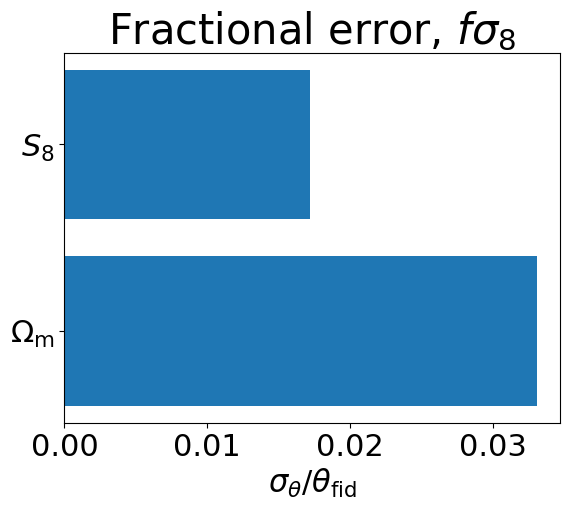

In [17]:
param_names = (r'$\Omega_\mathrm{m}$', r'$S_8$',
               #r'$w_0$', r'$w_a$',
               #r'$\gamma_0$', r'$\gamma_1$'
               )

fisher_inv = np.linalg.inv(fisher)
extract_params = cosmo_param_nr_fsig8
fid_params=fid_params_fsig8

fig,ax = plt.subplots(1,1)

plot_1d_error_frac(fisher_inv, fid_params, param_names, np.arange(cosmo_param_nr_fsig8), ax)
    
ax.set_title(r'Fractional error, $f\sigma_8$', fontsize=30)
ax.set_xlabel(r'$\sigma_\theta/\theta_\mathrm{fid}$')

Text(0.5, 0.98, '$f\\sigma_8$')

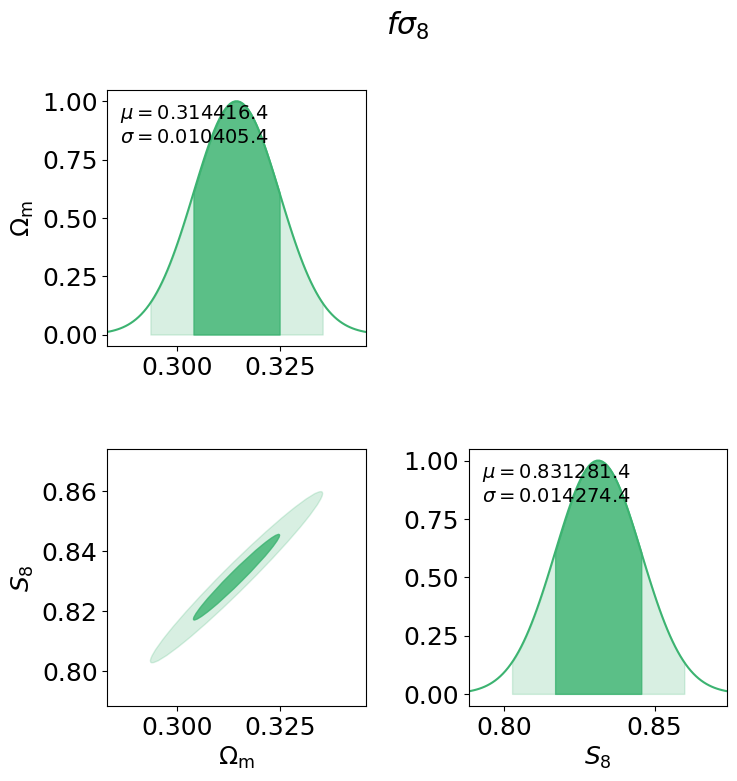

In [18]:
plt.rcParams.update({'font.size' : 18})
fig= plt.figure(figsize=(extract_params*4,extract_params*4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(fisher_inv, fid_params, np.array([j,i]),fill=True,antialiased=True,color='mediumseagreen')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(fisher_inv, fid_params, i, color='mediumseagreen')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle(r'$f\sigma_8$')

## $D_A(z)/r_s$

Next, we examine the `jax-cosmo` implementation of the angular diameter distance $D_A(z)$ and $r_s$ (sometimes referred to as $r_\mathrm{drag}$), the sound horizon at drag epoch by comparing the BAO quantity $D_A(z)/r_s$ to results from DESI.

In [19]:
def DA_rs(cosmo, z):
    a = z2a(z)
    D_A = jc.background.angular_diameter_distance(cosmo, a)
    r_s = jc.transfer.sh_d_AAN(cosmo)
    return D_A/r_s

#print(jc.transfer.sh_d_Eisenstein_Hu(fid_cosmo))

In [20]:
def compute_BAO_mean(params, z=z):
    cosmo_params = unpack_params_vec_BAO(params)
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-PL18_omegab,
                         #Omega_m = PL18_omegac+PL18_omegab,
                         #Omega_c = PL18_omegac,
                         Omega_b=PL18_omegab,
                         Omega_k=PL18_omegak,
                         h=cosmo_params[1],
                         #h=PL18_h,
                         n_s=PL18_ns,
                         #S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**.5, sigma8=PL18_sigma8,
                         S8=PL18_sigma8*(cosmo_params[0]/0.3)**.5, sigma8=PL18_sigma8,
                         #w0=cosmo_params[1], wa = cosmo_params[2],
                         w0 = PL18_w0, wa=PL18_wa,
                         gamma0=GR_gamma0, gamma1=GR_gamma1)
    BAOs = DA_rs(cosmo, z)
    return BAOs

In [21]:
fid_params_BAO = get_params_vec_BAO(fid_cosmo)
means = compute_BAO_mean(fid_params_BAO)

NameError: name 'get_params_vec_BAO' is not defined

In [ ]:
compute_BAO_jac = jax.jit(jax.jacfwd(compute_BAO_mean))

Compute the Fisher matrix from DESI BAO constraint forecasts. Fractional errors are taken from [arXiv:1611.00036v2](https://arxiv.org/abs/1611.00036) Table 2.3

In [ ]:
DESI_BAO_z = np.linspace(.65,1.85,num=13, endpoint=True)
DESI_BAO_err_pct = np.array([.82,.69,.69,.73,.89,.94,.96,1.5,
                         1.59,1.9,2.88,4.64,4.71])
DESI_BAO_err_frac = DESI_BAO_err_pct/100

means = compute_BAO_mean(fid_params_BAO, z=DESI_BAO_z)
jacobian = compute_BAO_jac(fid_params_BAO, z=DESI_BAO_z)
print(jacobian)

[[ 3.89213953 -3.45859593]
 [ 3.59513824 -3.65985668]
 [ 3.24994501 -3.81708101]
 [ 2.88203218 -3.93854565]
 [ 2.5092039  -4.03075286]
 [ 2.14352225 -4.09888175]
 [ 1.79193639 -4.14728037]
 [ 1.45630514 -4.17995156]
 [ 1.14319654 -4.19885993]
 [ 0.84946352 -4.20720811]
 [ 0.57895106 -4.20609595]
 [ 0.32734106 -4.19795152]
 [ 0.09647823 -4.18347109]]


In [ ]:
cov_mat = np.diag((DESI_BAO_err_frac*means)**2)
prc_mat = np.linalg.inv(cov_mat)

In [ ]:
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)
print(fisher)
print(np.linalg.inv(fisher))

(2, 2)
[[  8933.43550201 -10769.15763147]
 [-10769.15763147  14667.08972626]]
[[0.00097438 0.00071543]
 [0.00071543 0.00059348]]


### Add a prior onto the Fisher matrix
Approximating uniform priors with Gaussian distributions.

In [ ]:
h_prior_sigma = (1-(1+.2)/2)/3 #Approximating U[20,100]
om_b_prior_sigma = (0.1-(0.1+0.005)/2)/4 #Approximating U[.005,.1]

prior_mat = np.zeros_like(fisher)

prior_mat = prior_mat.at[1,1].set(h_prior_sigma**-2)

fisher_priors = fisher + prior_mat

(2, 2)
[[  8933.43550201 -10769.15763147]
 [-10769.15763147  14667.08972626]]
[[0.00097438 0.00071543]
 [0.00071543 0.00059348]]


Text(0.5, 1.0, '1-$\\sigma$ error magnitudes from BAO')

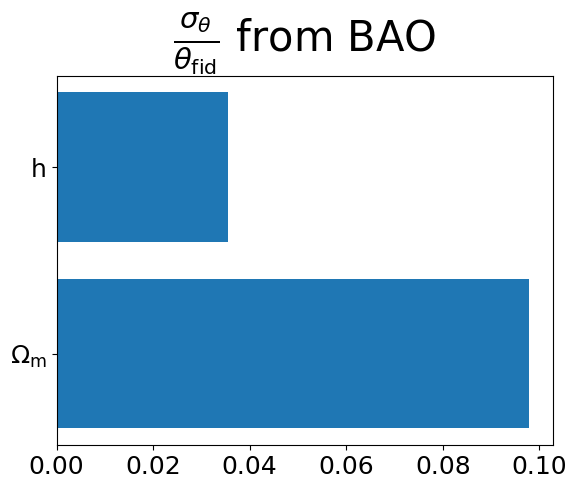

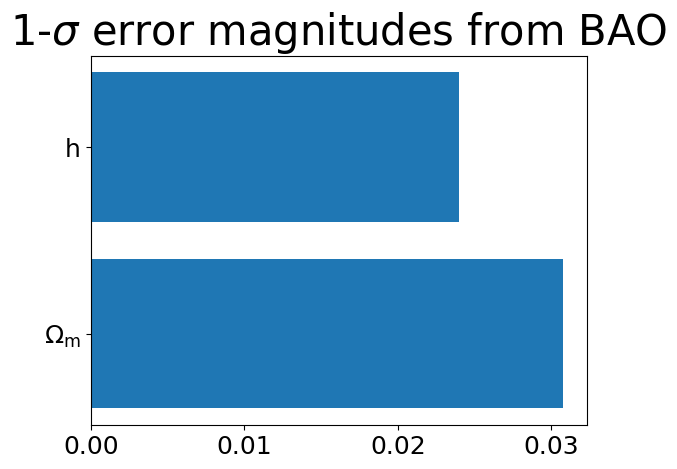

In [ ]:
param_names = (r'$\Omega_\mathrm{m}$',# r'$\Omega_\mathrm{b}$',
               'h',
               #r'$w_0$', r'$w_a$'
               )
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)
print(fisher)
print(np.linalg.inv(fisher))
#fisher_inv = np.linalg.inv(fisher)
fisher_inv = np.linalg.inv(fisher_priors)
extract_params = cosmo_param_nr_BAO
fid_params=fid_params_BAO

fig,ax = plt.subplots(1,1)

plot_1d_error_frac(fisher_inv, fid_params, param_names, np.arange(cosmo_param_nr_BAO), ax)
    
ax.set_title(r'$\frac{\sigma_\theta}{\theta_\mathrm{fid}}$ from BAO', fontsize=30)


fig,ax = plt.subplots(1,1)
plot_1d_error(fisher_inv, param_names, np.arange(cosmo_param_nr_BAO), ax)
ax.set_title(r'1-$\sigma$ error magnitudes from BAO', fontsize=30)

Text(0.5, 0.98, 'BAO')

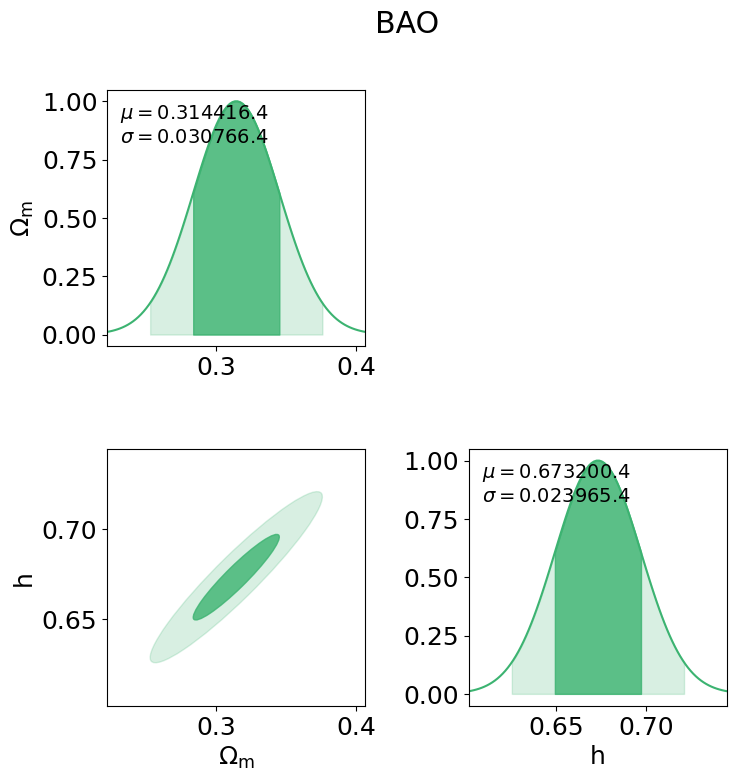

In [ ]:
plt.rcParams.update({'font.size' : 18})

fig= plt.figure(figsize=(extract_params*4,extract_params*4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(fisher_inv, fid_params, np.array([j,i]),fill=True,antialiased=True,color='mediumseagreen')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(fisher_inv, fid_params, i, color='mediumseagreen')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle('BAO')

# Checking $f\sigma_8$ and $D_a/r_s$ against CAMB

In [ ]:
#Get Planck 2018 Cosmological paramters from CAMB
import camb
pars = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
pars.want_zdrag = True
#pars.omnuh2 = 0
#print(pars)

In [ ]:
#Compute matter power spectrum so we can get fsigma8 from CAMB.

kmin=1e-4
kmax=2.0
nr_k_points=200

pars.set_matter_power(redshifts=zs, kmax=2*kmax)

results = camb.get_results(pars)

kh, z, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = nr_k_points)

Note: redshifts have been re-sorted (earliest first)


Text(0.5, 0, 'z')

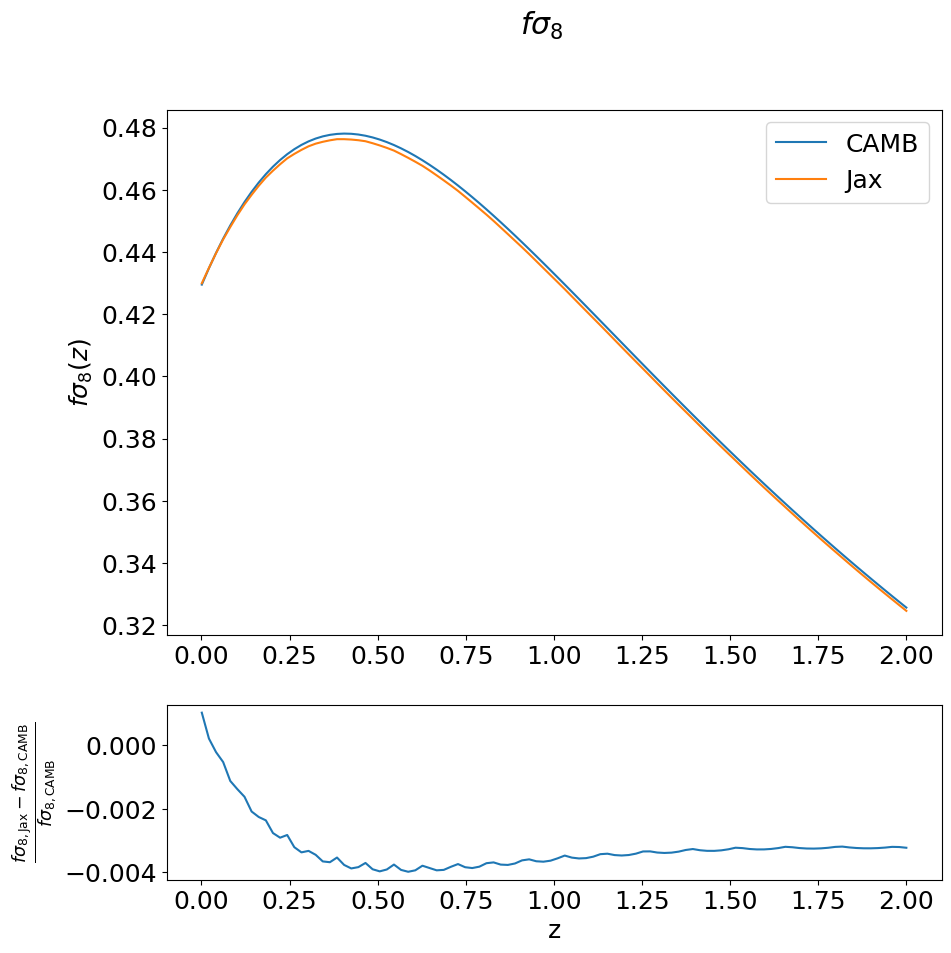

In [ ]:
fig,ax = plt.subplots(2,1,height_ratios=[3,1], figsize=(10,10))

zs = np.sort(zs)[::-1]
fs8_camb = results.get_fsigma8()
fs8_jax = fsigma8(fid_cosmo, zs)

fig.suptitle(r'$f\sigma_8$')

ax[0].plot(zs, fs8_camb, label='CAMB')
ax[0].plot(zs, fs8_jax, label='Jax')
ax[0].legend()
ax[0].set_ylabel(r'$f\sigma_8(z)$')

ax[1].plot(zs, (fs8_jax-fs8_camb)/fs8_camb)
ax[1].set_ylabel(r'$\frac{f\sigma_{8,\mathrm{Jax}}-f\sigma_{8,\mathrm{CAMB}}}{f\sigma_{8,\mathrm{CAMB}}}$')
ax[1].set_xlabel('z')

In [ ]:
def jc_eq_drag_for_camb(pars):
    #Compute k_eq, z_eq, z_drag as in Eisenstein-Hu 1997, arXiv:astro-ph/9709112v1
    T_2_7_sqr = (pars.TCMB / 2.7) ** 2
    w_m = pars.omch2+pars.ombh2
    w_b = pars.ombh2

    k_eq = 7.46e-2 * w_m / T_2_7_sqr / pars.h  # Eq. (3) [h/Mpc]
    z_eq = 2.50e4 * w_m / (T_2_7_sqr) ** 2  # Eq. (2)

    # z drag from Eq. (4)
    b1 = 0.313 * np.power(w_m, -0.419) * (1.0 + 0.607 * np.power(w_m, 0.674))
    b2 = 0.238 * np.power(w_m, 0.223)
    z_d = (
        1291.0
        * np.power(w_m, 0.251)
        / (1.0 + 0.659 * np.power(w_m, 0.828))
        * (1.0 + b1 * np.power(w_b, b2))
    )
    return k_eq, z_eq, z_d

In [ ]:
BAO_camb_arr = results.get_BAO(zs, pars)
DA_z = BAO_camb_arr[:,2]
rs_CAMB_bg = results.sound_horizon(results.get_derived_params()['zdrag'])


Text(0.5, 0, 'z')

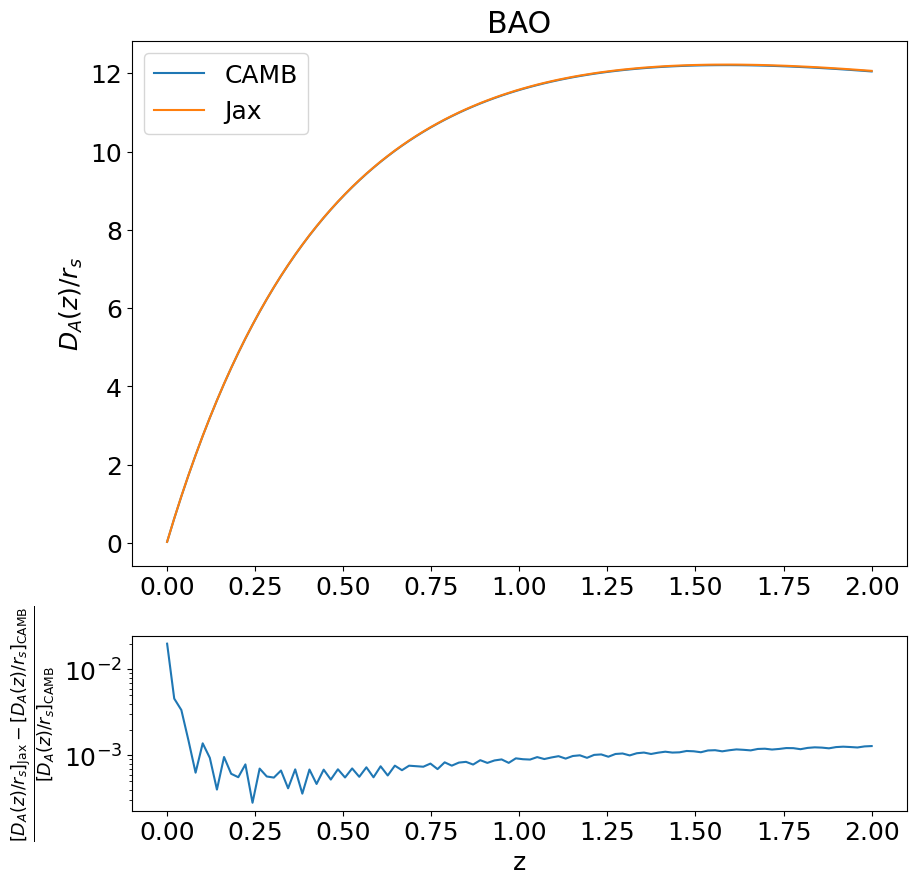

In [ ]:
fig,ax = plt.subplots(2,1,height_ratios=[3,1], figsize=(10,10))

zs = np.sort(zs)[::-1]
BAO_camb = DA_z/rs_CAMB_bg
BAO_jax = DA_rs(fid_cosmo, zs)

ax[0].set_title('BAO')

ax[0].plot(zs, BAO_camb, label='CAMB')
ax[0].plot(zs, BAO_jax, label='Jax')
ax[0].legend()
ax[0].set_ylabel(r'$D_A(z)/r_s$')

ax[1].semilogy(zs, (BAO_jax-BAO_camb)/BAO_camb)
ax[1].set_ylabel(r'$\frac{[D_A(z)/r_s]_\mathrm{Jax}-[D_A(z)/r_s]_\mathrm{CAMB}}{[D_A(z)/r_s]_\mathrm{CAMB}}$')
ax[1].set_xlabel('z')

Text(0.5, 0, 'z')

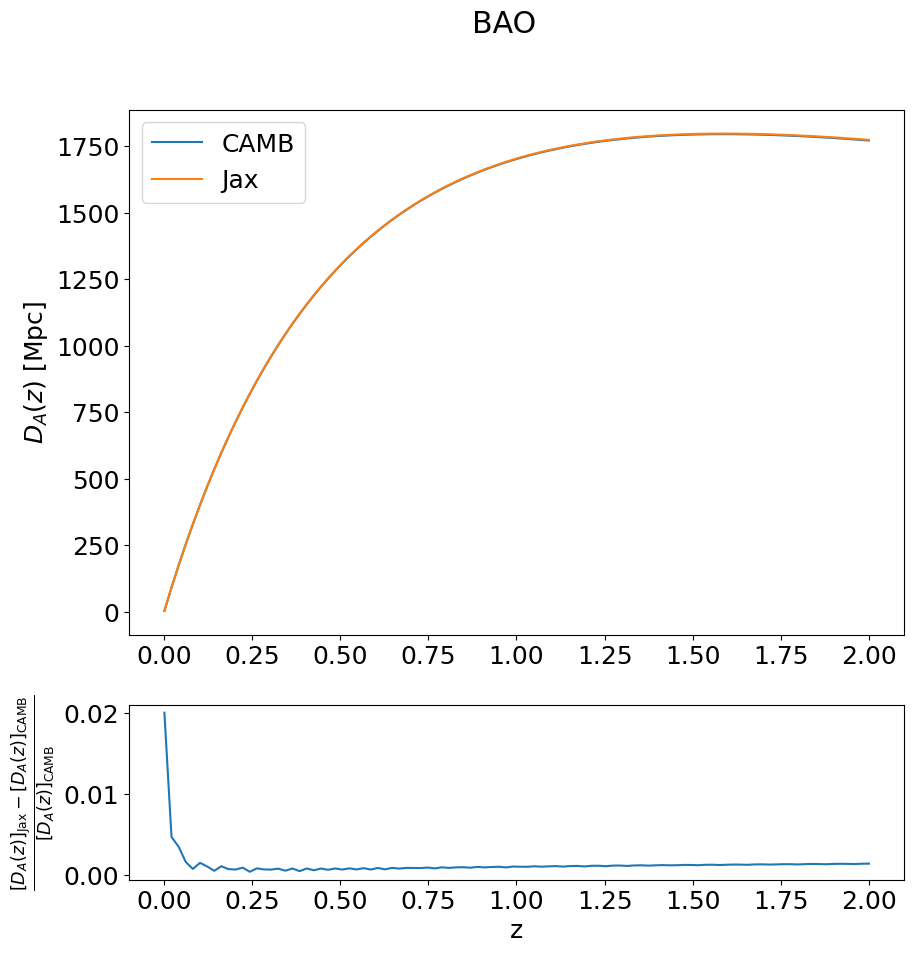

In [ ]:
fig,ax = plt.subplots(2,1,height_ratios=[3,1], figsize=(10,10))

zs = np.sort(zs)[::-1]
BAO_camb = DA_z
BAO_jax = DA_rs(fid_cosmo, zs)*jc.transfer.sh_d_AAN(fid_cosmo)/fid_cosmo.h

fig.suptitle(r'BAO')

ax[0].plot(zs, BAO_camb, label='CAMB')
ax[0].plot(zs, BAO_jax, label='Jax')
ax[0].legend()
ax[0].set_ylabel(r'$D_A(z)$ [Mpc]')

ax[1].plot(zs, (BAO_jax-BAO_camb)/BAO_camb)
ax[1].set_ylabel(r'$\frac{[D_A(z)]_\mathrm{Jax}-[D_A(z)]_\mathrm{CAMB}}{[D_A(z)]_\mathrm{CAMB}}$')
ax[1].set_xlabel('z')
#ax[1].set_xlim((.25,1.75))

### Compare various computations of the sound horizon at drag epoch

In [ ]:
def r_s_diff_from_camb(r_s):
    return (r_s-rs_CAMB_bg)/rs_CAMB_bg
print(rs_CAMB_bg)
print("Fractional difference in rs(zd) from CAMB")
print("EH only:", r_s_diff_from_camb(jc.transfer.sh_d_Eisenstein_Hu(fid_cosmo)/fid_cosmo.h)*100,"%")
print('EH + AAN z_drag:', r_s_diff_from_camb(jc.transfer.sh_d_EH_AAN(fid_cosmo)/fid_cosmo.h)*100,"%")
print('AAN, no neutrino:', r_s_diff_from_camb(jc.transfer.sh_d_AAN_no_neutrino(fid_cosmo)/fid_cosmo.h)*100,"%")
print("AAN, with neutrino:", r_s_diff_from_camb(jc.transfer.sh_d_AAN(fid_cosmo)/fid_cosmo.h)*100,"%")

NameError: name 'rs_CAMB_bg' is not defined

### Compare `jax-cosmo` computation of $f\sigma_8$ and BAO quantities with and without $\gamma$

Text(0.5, 0.98, 'Comparing observables with and without $\\gamma$ in Jax-cosmo')

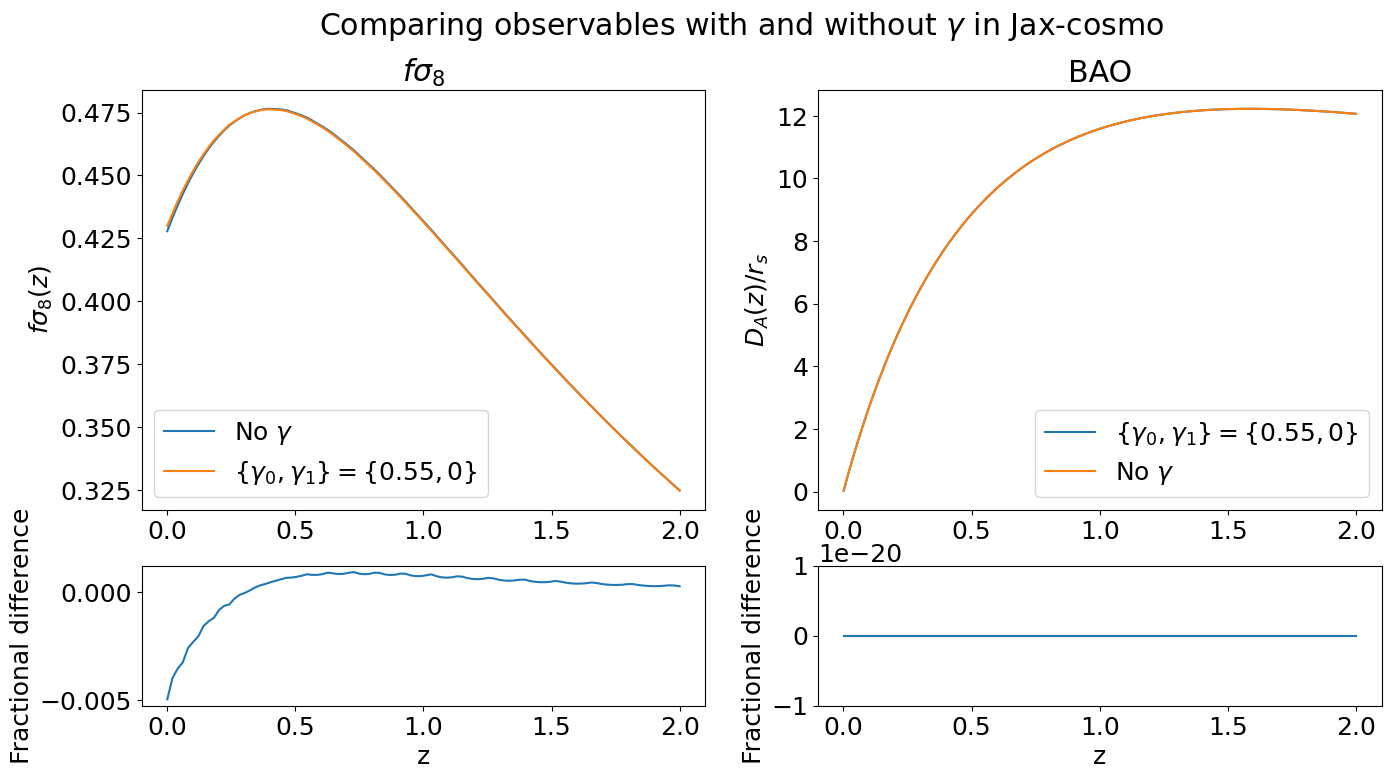

In [ ]:
fig,ax = plt.subplots(2,2,height_ratios=[3,1], figsize=(16,8))

zs = np.sort(zs)[::-1]
BAO_nogamma = DA_rs(fid_cosmo_nogamma, zs)
BAO_jax = DA_rs(fid_cosmo, zs)

ax[0,1].set_title(r'BAO')

ax[0,1].plot(zs, BAO_nogamma, label=r'$\{\gamma_0,\gamma_1\}=\{0.55,0\}$')
ax[0,1].plot(zs, BAO_jax, label=r'No $\gamma$')
ax[0,1].legend()
ax[0,1].set_ylabel(r'$D_A(z)/r_s$')

ax[1,1].plot(zs, (BAO_jax-BAO_nogamma)/BAO_jax)
ax[1,1].set_ylabel(r'Fractional difference')
ax[1,1].set_xlabel('z')
ax[1,1].set_ylim((-1e-20,1e-20))


zs = np.sort(zs)[::-1]
fs8_nogamma = fsigma8(fid_cosmo_nogamma, zs)
fs8_jax = fsigma8(fid_cosmo, zs)

ax[0,0].set_title(r'$f\sigma_8$')
ax[0,0].plot(zs, fs8_nogamma, label=r'No $\gamma$')
ax[0,0].plot(zs, fs8_jax, label='$\{\gamma_0,\gamma_1\}=\{0.55,0\}$')
ax[0,0].legend()
ax[0,0].set_ylabel(r'$f\sigma_8(z)$')

ax[1,0].plot(zs, (fs8_nogamma-fs8_jax)/fs8_nogamma)
ax[1,0].set_ylabel(r'Fractional difference')
ax[1,0].set_xlabel('z')

fig.suptitle(r'Comparing observables with and without $\gamma$ in Jax-cosmo')

## Combine $f\sigma_8$ and BAO Data Vectors

In [ ]:
cosmo_param_nr = 9
cosmo_param_nr_fsig8 = 4
cosmo_param_nr_BAO = 4

In [ ]:
def get_params_vec(cosmo):
#def get_params_vec(cosmo, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    return np.array([ 
        # Cosmological parameters [Omega_m, Omega_b, h, S8, ns, gamma, w0, wa] 
        #cosmo.Omega_k,
        cosmo.Omega_m, cosmo.Omega_b,
        cosmo.h, cosmo.ns, cosmo.S8,
        cosmo.w0, cosmo.wa,
        cosmo.gamma0, cosmo.gamma1
    ])

def unpack_params_vec(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    return cosmo

In [ ]:
def compute_mean(params, z):
    cosmo_params = unpack_params_vec(params)
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7], gamma1=cosmo_params[8]
                         )
    fsigma8s = fsigma8(cosmo, z[0])
    BAOs = DA_rs(cosmo, z[1])
    
    return np.append(fsigma8s, BAOs)

In [ ]:
compute_jac = jax.jit(jax.jacfwd(compute_mean))

In [ ]:
means = compute_mean(fid_params, (z_fs8, DESI_BAO_z))
jacobian = compute_jac(fid_params, (z_fs8, DESI_BAO_z))

In [ ]:
measured_vars = np.append((fs8_err_frac*means[0:fs8_pts])**2,(DESI_BAO_err_frac*means[fs8_pts:])**2)
cov_mat = np.diag(measured_vars)
prc_mat = np.linalg.inv(cov_mat)

In [ ]:
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)
print(fisher)
print(np.linalg.inv(fisher))

(2, 2)
[[20942314.4378452  40265354.727502  ]
 [40265354.727502   99355230.18422118]]
[[ 2.16257753e-07 -8.76420407e-08]
 [-8.76420407e-08  4.55832858e-08]]


Text(0.5, 0.98, '$f\\sigma8$ and BAO combined constraints')

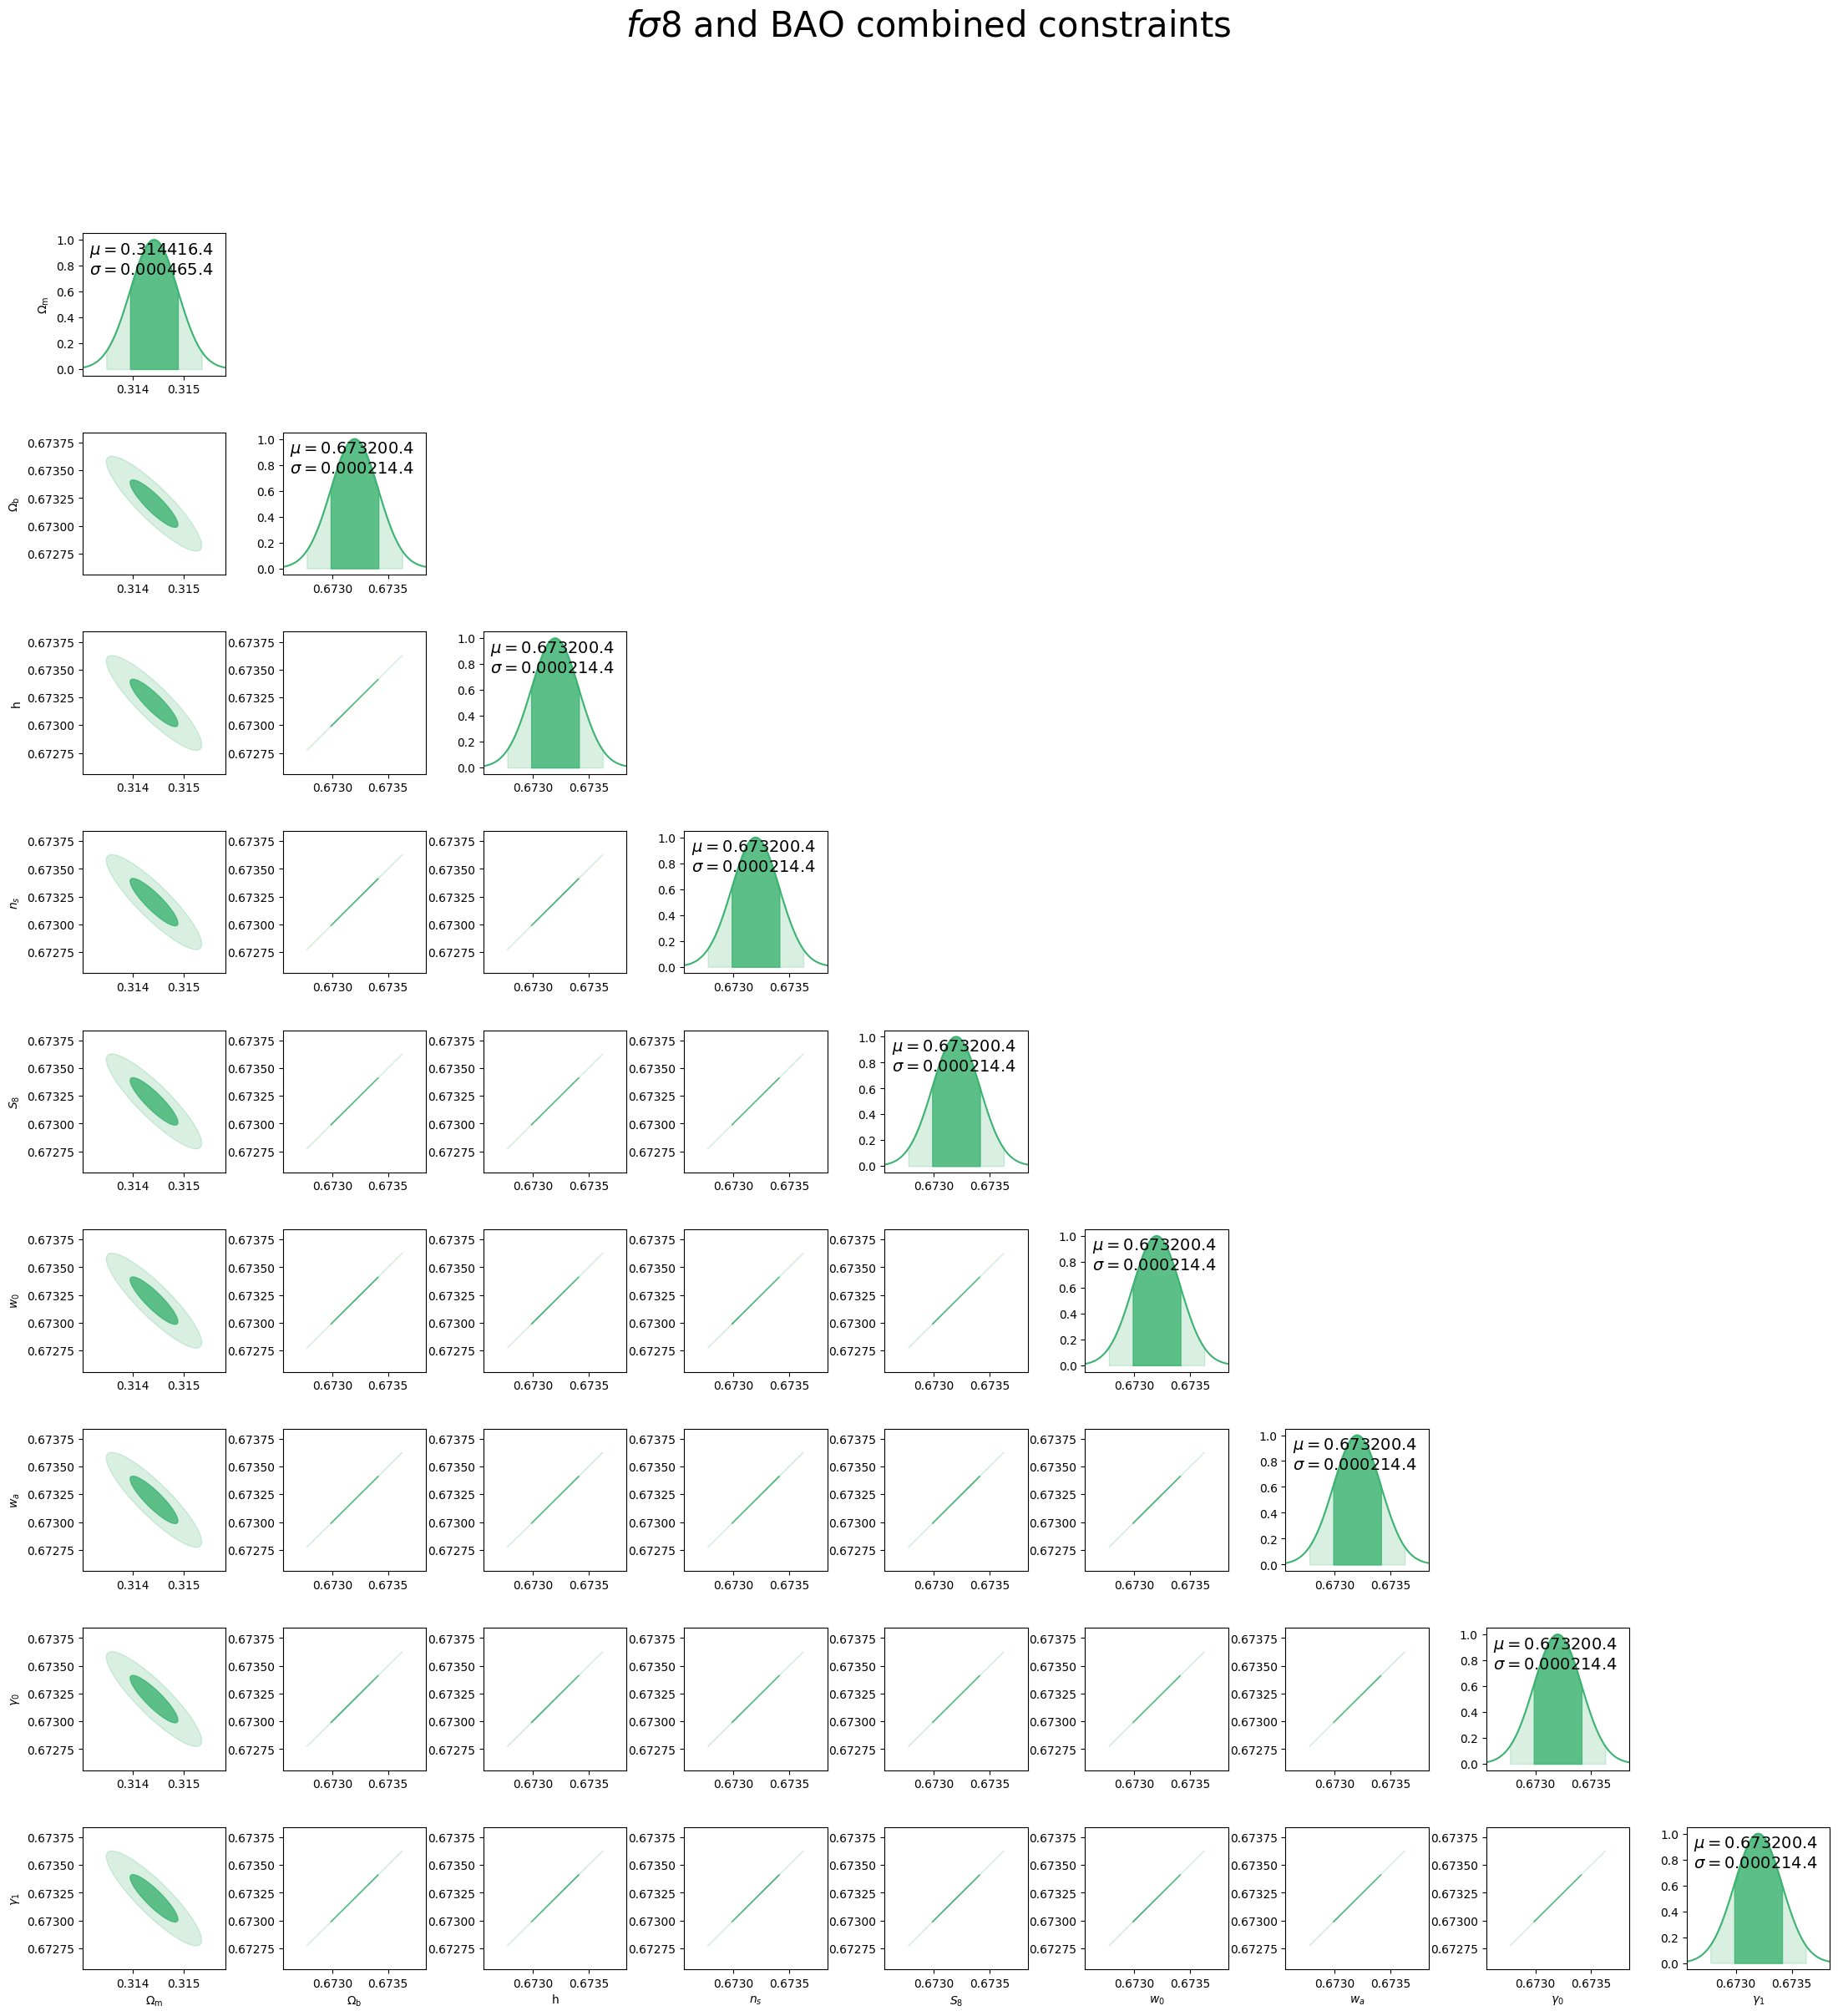

In [ ]:
extract_params=9
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$',r'$\gamma_1$')

fisher_inv = jax.scipy.linalg.inv(fisher)

fig= plt.figure(figsize=(extract_params*3, extract_params*3))
plt.rcParams.update({
    "font.size": 10})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(fisher_inv, fid_params, np.array([j,i]),fill=True,antialiased=True,color='mediumseagreen')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(fisher_inv, fid_params, i, color='mediumseagreen')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle(r'$f\sigma8$ and BAO combined constraints', fontsize=30)